In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel
from tqdm import tqdm

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [9]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Gland_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]

        from_folder = "../gland_data"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor

In [32]:
image_size = 128
batch_size = 1
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.2
    
    if(random.random() < p):
        jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
        image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    # if(random.random() < p):
    #     # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
    #     angle = 0.0
    #     max_dx = 0.05  # 水平平移比例
    #     max_dy = 0.3  # 垂直平移比例
    #     translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
    #     translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
    #     translate = (int(translate_x), int(translate_y))
    #     scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
    #     # scale = 1.0
    #     # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
    #     shear=[0.0, 0.0]
    #     image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
    #     mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
    
train_dataset = Gland_Dataset("../gland_data/benq_train_1.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Gland_Dataset("../gland_data/benq_test.csv", transform = test_augmentation, image_size = image_size)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)


In [33]:
# image.shape

In [34]:
print(len(train_dataset), len(test_dataset))

308 158


In [24]:
def get_pos(mask):
    row = []
    col = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i][j]:
                row.append(i)
                col.append(j)
    return np.mean(row), np.mean(col)

In [25]:
# train_mean = []
# train_std = []
# train_size_ratio = []
# train_row = []
# train_col = []
# for image_tensor, mask_tensor in tqdm(train_dataloader):
#     # print(image_tensor)
#     if image_tensor == None:
#         continue
#     mean = torch.mean(image_tensor[0][0])
#     std = torch.std(image_tensor[0][0])
#     size_ratio = torch.sum(mask_tensor[0][0]) / (mask_tensor[0][0].shape[0] * mask_tensor[0][0].shape[1])
#     row, col = get_pos(mask_tensor[0][0])
#     train_row.append(row)
#     train_col.append(col)
#     train_mean.append(mean)
#     train_std.append(std)
#     train_size_ratio.append(size_ratio)
# print("train mean : ", np.mean(train_mean))
# print("train std : ", np.mean(train_std))
# print("train size ratio : ", np.mean(train_size_ratio))
# print("train row : ", np.mean(train_row))
# print("train col : ", np.mean(train_col))

In [26]:
# test_mean = []
# test_std = []
# test_size_ratio = []
# test_row = []
# test_col = []
# for image_tensor, mask_tensor in tqdm(test_dataloader):
#     # print(image_tensor)
#     if image_tensor == None:
#         continue
#     mean = torch.mean(image_tensor[0][0])
#     std = torch.std(image_tensor[0][0])
#     size_ratio = torch.sum(mask_tensor[0][0]) / (mask_tensor[0][0].shape[0] * mask_tensor[0][0].shape[1])
#     row, col = get_pos(mask_tensor[0][0])
#     test_row.append(row)
#     test_col.append(col)
#     test_mean.append(mean)
#     test_std.append(std)
#     test_size_ratio.append(size_ratio)
# print("test mean : ", np.mean(test_mean))
# print("test std : ", np.mean(test_std))
# print("test size ratio : ", np.mean(test_size_ratio))
# print("test row : ", np.mean(test_row))
# print("test col : ", np.mean(test_col))

In [35]:
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def extract_images_from_loader(dataloader, max_images=5000):
    images = []
    for epoch in range(10):
        for image_tensor, mask_tensor in tqdm(dataloader):
            if image_tensor == None:
                continue
            images.append(image_tensor.view(-1).cpu().numpy())  # Flatten to 1D
            if len(images) >= max_images:
                return images
    return images

In [36]:
# 抽取圖片並壓平
train_images = extract_images_from_loader(train_dataloader, max_images=308 * 10)
test_images = extract_images_from_loader(test_dataloader, max_images=158)

 30%|██▉       | 47/158 [00:00<00:01, 65.24it/s]


In [37]:
# 合併
all_images = train_images + test_images
labels = ['train'] * len(train_images) + ['test'] * len(test_images)

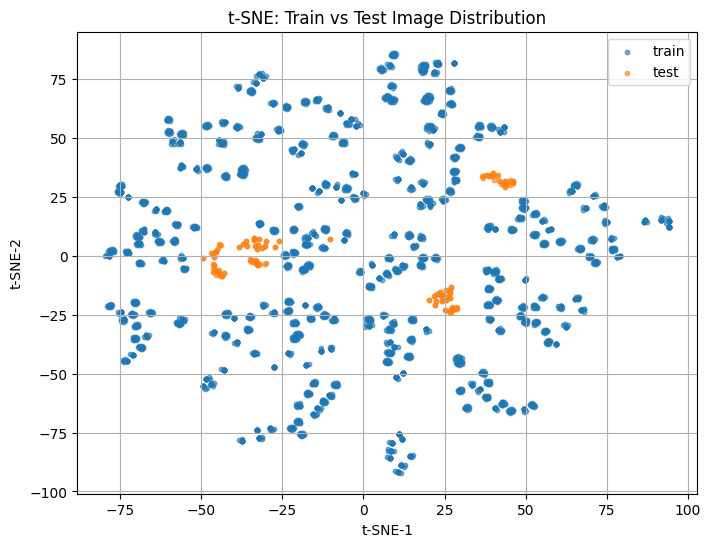

In [38]:
from sklearn.manifold import TSNE
all_images = np.array(train_images + test_images)
labels = ['train'] * len(train_images) + ['test'] * len(test_images)
# 執行 t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
tsne_result = tsne.fit_transform(all_images)

# 畫圖
tsne_x = tsne_result[:, 0]
tsne_y = tsne_result[:, 1]

plt.figure(figsize=(8, 6))
for label in ['train', 'test']:
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_x[idxs], tsne_y[idxs], label=label, alpha=0.6, s=10)
plt.title("t-SNE: Train vs Test Image Distribution")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
from scipy.spatial import distance_matrix
def compute_knn_distance(tsne_result, labels, k=5):
    tsne_result = np.array(tsne_result)
    labels = np.array(labels)

    train_points = tsne_result[labels == 'train']
    test_points = tsne_result[labels == 'test']

    dists = distance_matrix(test_points, train_points)  # shape (n_test, n_train)
    knn_dists = np.sort(dists, axis=1)[:, :k]           # 每個 test 找最近的 k 個 train
    mean_dist = np.mean(knn_dists)                      # 所有距離的平均值

    return mean_dist

# 使用範例
knn_avg_dist = compute_knn_distance(tsne_result, np.array(labels), k=10)
print(f"Test-to-Train average distance (k=10): {knn_avg_dist:.4f}")

Test-to-Train average distance (k=10): 9.8487
